In [6]:
# Dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data (FRED-MD)
df = pd.read_csv('../current.csv')

# Remove the first row (transformation codes)
transformation_codes = df.iloc[0]  # Transformation codes can be applied if needed
df = df.iloc[1:]

# Set the first column as the index and datetime
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)

# Dropna
data = df.dropna()

# Create train data and target
target = (data['CPIAUCSL'].diff(12) / data['CPIAUCSL'].shift(12)) * 100
target = target.shift(-12).dropna()

# Difference all data (except CPIAUCSL)
data = data.diff().dropna()
data['CPIAUCSL'] = target
data = data.dropna()


In [ ]:
# Run VAR experiment
variance = 1
for forecast_horizon in range(4, 12 * 5 + 4, 12):
    train_data = data.iloc[:-forecast_horizon].copy()

    # Normalize data
    train_data = (train_data - train_data.mean()) / train_data.std()
    
    # Apply PCA on predictors only
    predictors = train_data.drop(columns=['CPIAUCSL'])
    pca = PCA(n_components=variance)
    predictors_pca = pca.fit_transform(predictors)

    # Combine with target
    train_data_pca = pd.DataFrame(predictors_pca, index=predictors.index, columns=[f"PC{i}" for i in range(predictors_pca.shape[1])])
    train_data_pca['CPIAUCSL'] = target.iloc[:len(train_data_pca)].values

    for context_window in [1, 2, 4, 6, 12, 24]:
        model = VAR(train_data_pca)
        results = model.fit(context_window)

        # Forecast
        forecast_input = train_data_pca.values[-context_window:]
        forecast_all = results.forecast(y=forecast_input, steps=forecast_horizon)

        # Get CPIAUCSL predictions
        cpi_index = train_data_pca.columns.get_loc("CPIAUCSL")
        y_pred = forecast_all[:, cpi_index]
        y_true = data.iloc[-forecast_horizon:]["CPIAUCSL"].values

        # Log metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        new_row = {
            'lags': forecast_horizon,
            'context_window': context_window,
            'variance': variance,
            'normalized': True,
            'rmse': rmse,
            'mae': mae,
            'forecast': list(y_pred),
            'actual': list(y_true)
        }

        # Save
        fp = "var.csv"
        var_log = pd.read_csv(fp)
        var_log = pd.concat([var_log, pd.DataFrame([new_row])], ignore_index=True)
        var_log.to_csv(fp, index=False)


/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/js/macroeconvue/modeling/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associa

In [ ]:
# Analyze var.csv for correlation between context_window and forecast_horizon on RMSE
import pandas as pd

data = pd.read_csv("var.csv")[["lags", "context_window", "rmse"]]
data

,forecast_horizon,context_window,variance,normalized,rmse,mae,forecast,actual
0,4,1,0.95,False,0.600562,0.576273,"[np.float64(3.2353270240416907), np.float64(3....","[np.float64(2.923565791719739), np.float64(2.5..."
1,4,2,0.95,False,0.510820,0.488798,"[np.float64(3.193963292857699), np.float64(3.1...","[np.float64(2.923565791719739), np.float64(2.5..."
2,4,4,0.95,False,0.575847,0.553455,"[np.float64(3.2362094333029834), np.float64(3....","[np.float64(2.923565791719739), np.float64(2.5..."
3,4,6,0.95,False,0.589661,0.564741,"[np.float64(3.232153052236977), np.float64(3.2...","[np.float64(2.923565791719739), np.float64(2.5..."
4,4,12,0.95,False,0.586070,0.567722,"[np.float64(3.3034340800708137), np.float64(3....","[np.float64(2.923565791719739), np.float64(2.5..."
...,...,...,...,...,...,...,...,...
175,52,2,1.00,True,3.402569,2.694701,"[np.float64(-0.10766096291497362), np.float64(...","[np.float64(1.251895475543966), np.float64(1.3..."
176,52,4,1.00,True,3.570111,2.835030,"[np.float64(-0.046615272321030854), np.float64...","[np.float64(1.251895475543966), np.float64(1.3..."
177,52,6,1.00,True,3.581922,2.851174,"[np.float64(-0.04308561386912674), np.float64(...","[np.float64(1.251895475543966), np.float64(1.3..."
178,52,12,1.00,True,3.296644,2.636902,"[np.float64(0.01407877571373932), np.float64(0...","[np.float64(1.251895475543966), np.float64(1.3..."


In [2]:
# Look at hyperparemeters
import pandas as pd 
data = pd.read_csv("var.csv")

# change normalized to 1/0
data['normalized'] = data['normalized'].replace({True: 1, False: 0})

# Calculate outliers for rmse
def calculate_iqr(df):
    q1 = df['rmse'].quantile(0.25)
    q3 = df['rmse'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound
lower_bound, upper_bound = calculate_iqr(data)
# Remove outliers
data = data[(data['rmse'] >= lower_bound) & (data['rmse'] <= upper_bound)]

# Regression between context_window and forecast_horizon 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Fit the model
model = smf.ols(formula='rmse ~ forecast_horizon + lags + variance + normalized', data=data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   rmse   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     33.30
Date:                Sat, 12 Apr 2025   Prob (F-statistic):           4.21e-20
Time:                        09:50:21   Log-Likelihood:                -274.11
No. Observations:                 162   AIC:                             558.2
Df Residuals:                     157   BIC:                             573.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.1102      1.276  

/tmp/ipykernel_2446/461283998.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['normalized'] = data['normalized'].replace({True: 1, False: 0})


In [13]:
# Look at hyperparemeters
import pandas as pd 
data = pd.read_csv("var.csv")

# change normalized to 1/0
data['normalized'] = data['normalized'].replace({True: 1, False: 0})

# Calculate outliers for rmse
def calculate_iqr(df):
    q1 = df['rmse'].quantile(0.25)
    q3 = df['rmse'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound
lower_bound, upper_bound = calculate_iqr(data)
# Remove outliers
data = data[(data['rmse'] >= lower_bound) & (data['rmse'] <= upper_bound)]

# Average RMSE for each variance
avg_var_rmse = data.groupby('variance')['rmse'].mean().reset_index()
display(avg_var_rmse)

avg_lag_rmse = data.groupby('lags')['rmse'].mean().reset_index()
display(avg_lag_rmse)

best_lags = data.loc[data.groupby('forecast_horizon')['rmse'].idxmin()]
best_lags = best_lags.sort_values(by='forecast_horizon')
display(best_lags)


/tmp/ipykernel_7948/3427106256.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['normalized'] = data['normalized'].replace({True: 1, False: 0})


,variance,rmse
0,0.80,2.420324
1,0.90,1.943598
2,0.95,2.505791
3,1.00,2.082699


,lags,rmse
0,1,2.235457
1,2,1.912024
2,4,1.906059
3,6,2.104408
4,12,2.803539
5,24,3.062364


,forecast_horizon,lags,variance,normalized,rmse,mae,forecast,actual
92,4,4,0.80,1,0.097593,0.082784,"[np.float64(2.923791452280385), np.float64(2.6...","[np.float64(2.923565791719739), np.float64(2.5..."
7,16,2,0.95,0,0.276401,0.231356,"[np.float64(3.7195934917842686), np.float64(3....","[np.float64(3.271780511700916), np.float64(3.7..."
163,28,2,1.00,1,0.552732,0.440547,"[np.float64(8.34400960576952), np.float64(7.97...","[np.float64(8.44981874600173), np.float64(8.21..."
20,40,4,0.95,0,2.130510,1.732059,"[np.float64(7.9280500135764935), np.float64(6....","[np.float64(5.257577164793664), np.float64(5.1..."
89,52,24,0.80,0,2.919818,2.234124,"[np.float64(0.10335118378638175), np.float64(0...","[np.float64(1.251895475543966), np.float64(1.3..."


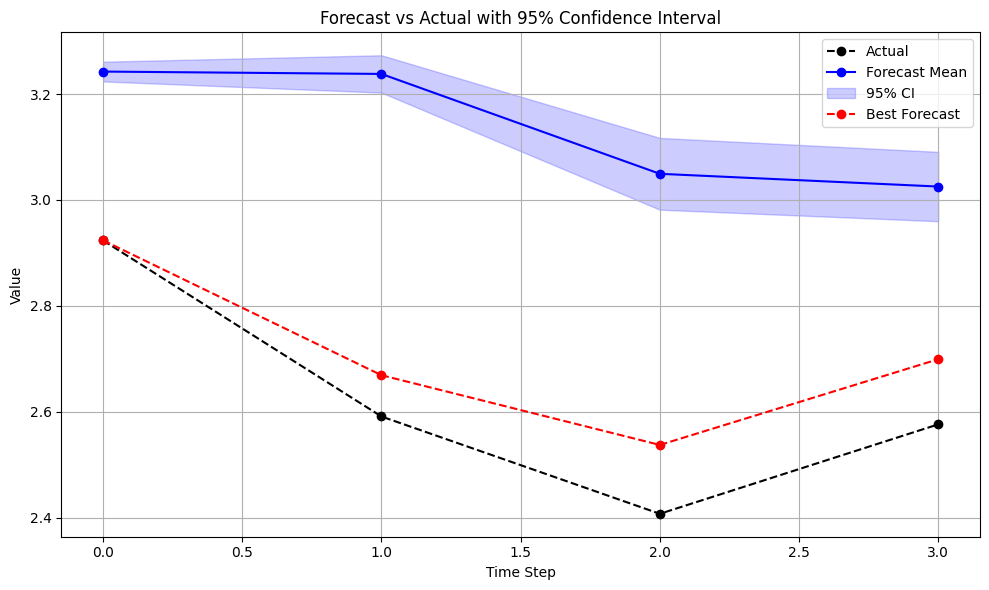

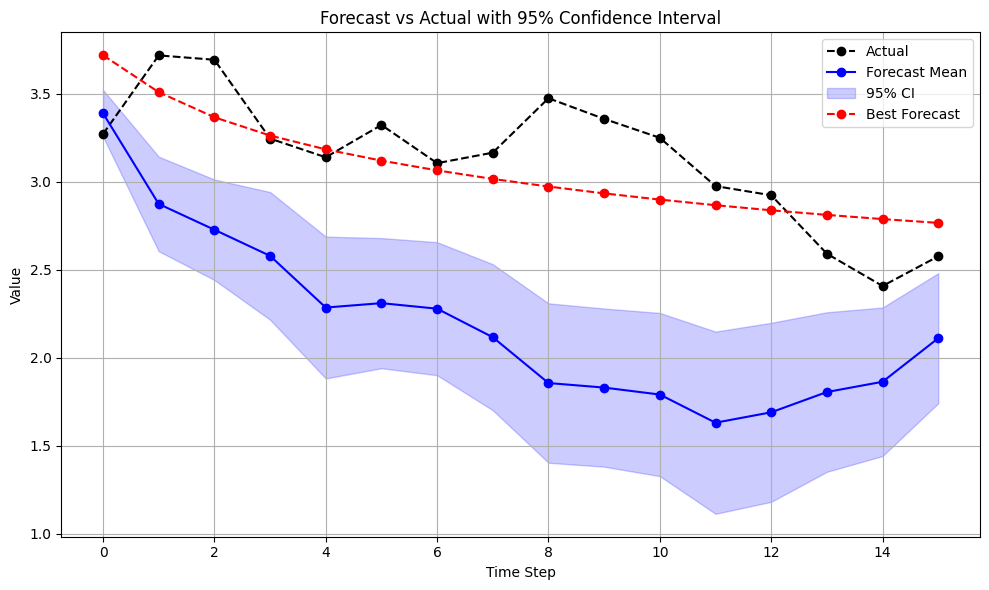

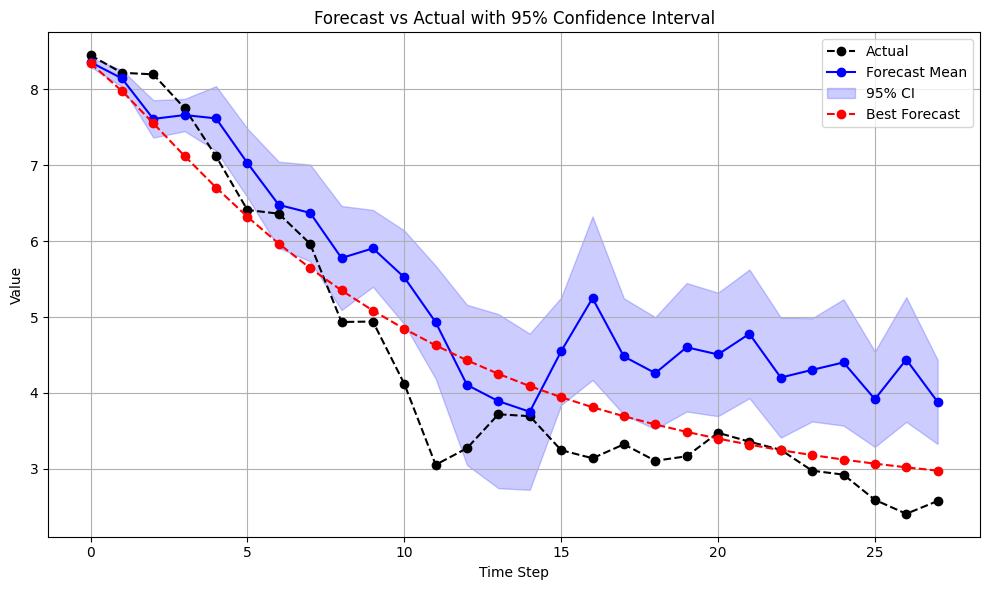

In [17]:
# Look at hyperparemeters
import pandas as pd 
import numpy as np
data = pd.read_csv("var.csv")

def remove_outliers_iqr(data, k=1.5):
    """Removes outliers from a 1D array using the IQR method."""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return data[(data >= lower) & (data <= upper)]

for horizon in [4, 16, 28]:
    temp = data[data['forecast_horizon'] == horizon].copy()
    forecasts = np.array([np.array(eval(temp['forecast'].values[idx])) for idx in range(len(temp))])
    actual = np.array(eval(temp['actual'].values[0]))
    # Remove outliers
    filtered_forecasts = []
    for t in range(forecasts.shape[1]):
        step_values = forecasts[:, t]
        step_filtered = remove_outliers_iqr(step_values)
        filtered_forecasts.append(step_filtered)
    

    # Plot
    import matplotlib.pyplot as plt

    # Now calculate mean and CI
    forecast_mean = np.array([v.mean() for v in filtered_forecasts])
    forecast_std = np.array([v.std(ddof=1) for v in filtered_forecasts])
    n_effective = np.array([len(v) for v in filtered_forecasts])
    stderr = forecast_std / np.sqrt(n_effective)
    ci = 1.96 * stderr  # 95% CI

    # Time axis
    x = np.arange(len(actual))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, actual, label='Actual', color='black', linestyle='--', marker='o')
    plt.plot(x, forecast_mean, label='Forecast Mean', color='blue', marker='o')
    plt.fill_between(x, forecast_mean - ci, forecast_mean + ci, color='blue', alpha=0.2, label='95% CI')
    # Add the best forecast (min RMSE)
    var_horizon = temp[temp['rmse'] == temp['rmse'].min()]
    var_forecast = np.array(eval(var_horizon['forecast'].values[0]))
    plt.plot(x, var_forecast, label='Best Forecast', color='red', linestyle='--', marker='o')


    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Forecast vs Actual with 95% Confidence Interval')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()